In [88]:
import pickle
import numpy as np

import keras.backend as K
import matplotlib.pyplot as plt
import re
import tarfile

from keras.models import Model,Sequential
from keras.layers import Dense, Embedding, Input, Lambda, Reshape, add, dot, Activation, Softmax
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, RMSprop

from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input, Activation, Dense, Permute, Dropout
from tensorflow.keras.layers import add, dot, concatenate
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop

In [30]:
with open("train_qa.txt", "rb") as fp:   # Unpickling, read-binary
    train_data =  pickle.load(fp)

In [31]:
with open("test_qa.txt", "rb") as fp:   # Unpickling
    test_data =  pickle.load(fp)


In [32]:
def tokenize(sent):
    return [x.strip() for x in re.split('(\W+?)', sent) if x.strip()]

In [54]:
def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            substory = None
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data

In [55]:
def get_stories(f, only_supporting=False, max_length=None):
    '''Given a file name, read the file,
    retrieve the stories,
    and then convert the sentences into a single story.
    If max_length is supplied,
    any stories longer than max_length tokens will be discarded.
    '''
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data if not max_length or len(flatten(story)) < max_length]
    return data

In [56]:
# Create a set that holds the vocab words
vocab = set()

In [57]:
all_data = test_data + train_data

In [58]:
for story, question , answer in all_data:
    # In case you don't know what a union of sets is:
    # https://www.programiz.com/python-programming/methods/set/union
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))
vocab.add('no')
vocab.add('yes')

In [59]:
vocab_size = len(vocab) + 1 # we add an extra space to hold a 0 for Keras's pad_sequences

In [60]:
story_maxlen = max([len(data[0]) for data in all_data])

In [65]:
query_maxlen = max([len(data[1]) for data in all_data])

In [67]:
# integer encode sequences of words
tokenizer = Tokenizer(filters=[])   # provide empty list for filter out
tokenizer.fit_on_texts(vocab)


In [68]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [69]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [75]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=story_maxlen,max_question_len=query_maxlen):
    '''
    INPUT:

    data: consisting of Stories,Queries,and Answers
    word_index: word index dictionary from tokenizer
    max_story_len: the length of the longest story (used for pad_sequences function)
    max_question_len: length of the longest question (used for pad_sequences function)


    OUTPUT:

    Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
    answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
    output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.

    Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)
    '''


    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []


    for story, query, answer in data:

        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]

        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(vocab_size)  # this includes +1 for padding

        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        y[word_index[answer]] = 1

        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)

    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.

    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [78]:
word2idx = tokenizer.word_index
  # convert stories from strings to lists of integers
inputs_train, queries_train, answers_train = vectorize_stories(
    train_data)
inputs_test, queries_test, answers_test = vectorize_stories(
    test_data
  )

In [101]:
def build_memory_network():
    # Input layers
    input_sequence = Input((story_maxlen,))
    question = Input((query_maxlen,))



    # Embedding layers

    embedding_dim = 128

# Input gets embedded to a sequence of vectors
    input_encoder_m = Sequential()
    input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim= embedding_dim))
    input_encoder_m.add(Dropout(0.3))

    # embed the input into a sequence of vectors of size query_maxlen
    input_encoder_c = Sequential()
    input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=query_maxlen))
    input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)
    # embed the question into a sequence of vectors
    question_encoder = Sequential()
    question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embedding_dim,
                               input_length=query_maxlen))
    question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

    # encode input sequence and questions (which are indices) to sequences of dense vectors
    input_encoded_m = input_encoder_m(input_sequence)
    input_encoded_c = input_encoder_c(input_sequence)
    question_encoded = question_encoder(question)


# This encoder will output:




    # shape: `(samples, story_maxlen, query_maxlen)`
    match = dot([input_encoded_m, question_encoded], axes=(2, 2))
    match = Activation('softmax')(match)

    # add the match matrix with the second input vector sequence
    response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
    response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

    answer = concatenate([response, question_encoded])

    answer = LSTM(32)(answer)

    # Regularization with Dropout
    answer = Dropout(0.5)(answer)
    answer = Dense(vocab_size)(answer)

    answer = Activation('softmax')(answer)

# build the final model
    model = Model([input_sequence, question], answer)
    optimizer = RMSprop(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])







    return model

In [ ]:
# train the model
model=build_memory_network()
r = model.fit(
  [inputs_train, queries_train],
  answers_train,
  epochs=120,
  batch_size=32,
  validation_data=([inputs_test, queries_test], answers_test)
)

Epoch 1/120
313/313 [==============================] - 11s 26ms/step - loss: 0.7413 - accuracy: 0.5053 - val_loss: 0.6972 - val_accuracy: 0.5030
Epoch 2/120
313/313 [==============================] - 6s 20ms/step - loss: 0.7052 - accuracy: 0.5053 - val_loss: 0.7289 - val_accuracy: 0.4970
Epoch 3/120
313/313 [==============================] - 7s 23ms/step - loss: 0.7035 - accuracy: 0.5024 - val_loss: 0.6964 - val_accuracy: 0.4970
Epoch 4/120
313/313 [==============================] - 6s 19ms/step - loss: 0.7011 - accuracy: 0.5032 - val_loss: 0.6938 - val_accuracy: 0.5030
Epoch 5/120
313/313 [==============================] - 8s 25ms/step - loss: 0.7006 - accuracy: 0.4998 - val_loss: 0.6928 - val_accuracy: 0.4970
Epoch 6/120
313/313 [==============================] - 6s 19ms/step - loss: 0.6659 - accuracy: 0.5821 - val_loss: 0.5537 - val_accuracy: 0.7200
Epoch 7/120
313/313 [==============================] - 7s 22ms/step - loss: 0.5437 - accuracy: 0.7309 - val_loss: 0.4581 - val_accuracy

In [113]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 156)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 sequential_5 (Sequential)   (None, None, 128)            4864      ['input_5[0][0]']             
                                                                                                  
 sequential_7 (Sequential)   (None, 6, 128)               4864      ['input_6[0][0]']             
                                                                                              

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


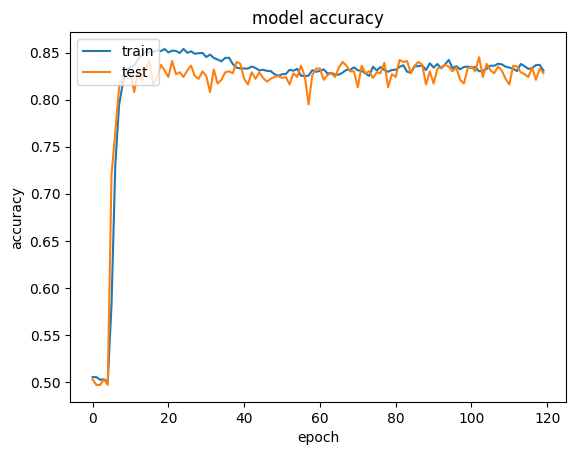

In [120]:
%matplotlib inline
print(r.history.keys())
# summarize history for accuracy
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy.png', dpi=180, facecolor='white')
plt.show()